# Simulation 

In [1]:
#Import
from diffractio import degrees, mm, plt, np, um
from diffractio.scalar_sources_X import Scalar_source_X
from diffractio.scalar_masks_X import Scalar_mask_X
from diffractio.utils_drawing import draw_several_fields
from diffractio.utils_optics import beam_width_1D, FWHM2D, MTF_ideal, MTF_parameters,FWHM1D
from diffractio.scalar_masks_XZ import Scalar_mask_XZ
from diffractio.scalar_masks_XY import Scalar_mask_XY
import math
import matplotlib.pyplot as plt
import matplotlib

In [2]:
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

figsize = (6,5); 

# Fonts
plt_label_size = 12; legend_font_size = plt_label_size*1 ; 

# Line thicknesses
axes_linewidth = 3; lines_linewidth = axes_linewidth; 

# Tick sizes
major_tick_size = 6; minor_tick_size = major_tick_size / 2; tick_width = major_tick_size / 4

kw_args = { 'figure.figsize' : figsize, # 'font.family' : 'cursive', # 'font.monospace' : 'Fixed',
           
            'axes.linewidth': axes_linewidth, 'lines.linewidth': lines_linewidth, 'axes.labelsize' : plt_label_size, 
           
            'axes.grid' : True, 'grid.alpha' : 0.25, 'grid.color' :  'gray', 'grid.linestyle': '--',
           
            'legend.fontsize': legend_font_size,  'legend.title_fontsize' : legend_font_size, 
            
           
            'xtick.direction':'in', 'xtick.major.size' : major_tick_size, 'xtick.major.width': tick_width, 'xtick.major.pad': major_tick_size, 
            'xtick.minor.size' : minor_tick_size, 'xtick.minor.width': tick_width, 'xtick.labelsize': plt_label_size, 'xtick.minor.visible': True,
            'xtick.color' : 'k', 'xtick.top': True,
             
            'ytick.direction':'in', 'ytick.major.size' : major_tick_size, 'ytick.major.width': tick_width, 'ytick.major.pad': major_tick_size,
            'ytick.minor.size' : minor_tick_size, 'ytick.minor.width': tick_width, 'ytick.labelsize': plt_label_size,  'ytick.minor.visible': True,
            'ytick.color' : 'k', 'ytick.right': True,
           
           'savefig.bbox': "tight"
            
           }

plt.rcParams.update(kw_args)

In [3]:
#Gaussian Beam

wavelength =  0.6328 * um
fwhm_at_50mm_lens = 1556*um
w0 = 0.8493218* fwhm_at_50mm_lens # um  https://support.zemax.com/hc/en-us/articles/1500005488161-How-to-convert-FWHM-measurements-to-1-e-2-halfwidths

#Sample Size

num_sample=  500000


#Second Lens 

second_lens_diameter = 25.4 * mm
range_of_second_lens = np.linspace(-second_lens_diameter/2 , second_lens_diameter/2 , num_sample)
focal_length_second_lens = 200 * mm

second_lens = Scalar_mask_X(x=range_of_second_lens, wavelength=wavelength)
second_lens.lens(x0=0.0, focal=focal_length_second_lens, radius=second_lens_diameter/ 2)


#First Lens

first_lens_diameter = 25.4 * mm
focal_length_first_lens = 50 * mm

first_lens = Scalar_mask_X(x=range_of_second_lens, wavelength=wavelength)
first_lens.lens(x0=0.0, focal=focal_length_first_lens, radius=first_lens_diameter/ 2)

array([1.      , 0.999992, 0.999984, ..., 0.999984, 0.999992, 1.      ])

# Collimated Gaussian Beam

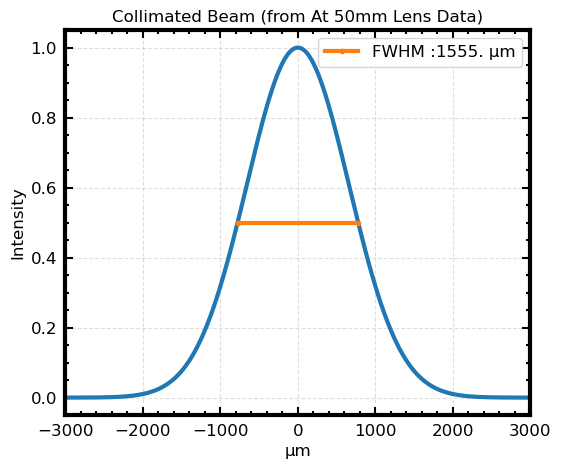

In [4]:
collimated_beam = Scalar_source_X(x=range_of_second_lens, wavelength=wavelength)
collimated_beam.gauss_beam(A=1,x0=0,z0=0*mm, w0= w0 ,theta=0 * degrees) 

fwhm_incident_beam = FWHM1D(collimated_beam.x,collimated_beam.intensity(),has_draw= False)
plt.plot(collimated_beam.x,collimated_beam.intensity())

#FWHM LINE
x1, y1 = [-fwhm_incident_beam/2, fwhm_incident_beam/2], [max(np.abs(collimated_beam.u)**2)/2, max(np.abs(collimated_beam.u)**2)/2]
plt.plot(x1, y1, marker = '.',label="FWHM :" + str(fwhm_incident_beam)[:5]+ " µm")

plt.title("Collimated Beam (from At 50mm Lens Data)")
plt.xlabel("µm")
plt.ylabel("Intensity")
plt.xlim(-3000,3000)
plt.legend()
plt.show()


In [62]:
fwhm_prop_cgbeam_array = []
for i in np.arange(10,1000,50):
    prop_collimated_beam = collimated_beam.RS(z=i*mm,verbose=False)
    fwhm_prop_collimated_beam = FWHM1D(prop_collimated_beam.x,prop_collimated_beam.intensity(),has_draw= False)
    fwhm_prop_cgbeam_array.append(fwhm_prop_collimated_beam)

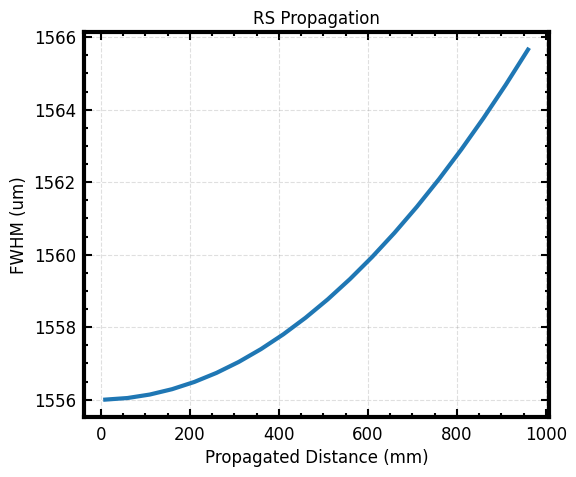

In [63]:
plt.plot(np.arange(10,1000,50),fwhm_prop_cgbeam_array)
plt.xlabel("Propagated Distance (mm)")
plt.ylabel("FWHM (um)")
plt.title("RS Propagation")
plt.show()

## RS (Diffracito) vs Spot Size Formula

In [64]:
fwhm_array_collimated=[]
for i in np.arange(-0.05,0,0.001):
    shift_in_focal_length_first_lens = i*mm
    at_first_lens = collimated_beam * first_lens
    first_lens_f = at_first_lens.RS(z=1 *(focal_length_first_lens + shift_in_focal_length_first_lens),verbose=False)
    fwhm_first_lens_f = FWHM1D(first_lens_f.x,first_lens_f.intensity(),has_draw= False)
    fwhm_array_collimated.append(fwhm_first_lens_f)

In [67]:
spot_size = 8.94 #https://www.lasercalculator.com/laser-spot-size-calculator/

In [68]:
min(fwhm_array_collimated),

(8.983516272635825,)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


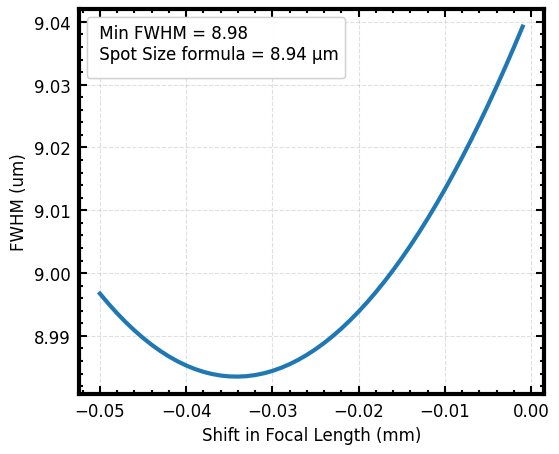

In [69]:
plt.plot(np.arange(-0.05,0,0.001),fwhm_array_collimated)
legend1 = plt.legend(title= " Min FWHM = %.2f\n Spot Size formula = %.2f µm" 
               %(min(fwhm_array_collimated), spot_size ) )

# Add the first legend to the current axes
plt.gca().add_artist(legend1)

plt.xlabel("Shift in Focal Length (mm)")
plt.ylabel("FWHM (um)")
plt.show()

# without 50mm Lens with 200mm Lens

In [70]:
fwhm_array_wout_first_lens = []
for i in np.arange(-0.14,-0.08,0.005):
    shift_in_focal_length_second_lens = i*mm

    
    at_second_lens = collimated_beam * second_lens
    without_first_lens = at_second_lens.RS(z= focal_length_second_lens + shift_in_focal_length_second_lens,verbose=False)
    fwhm_without_first_lens = FWHM1D(without_first_lens.x,without_first_lens.intensity(),has_draw= False)
    fwhm_array_wout_first_lens.append(fwhm_without_first_lens)
    


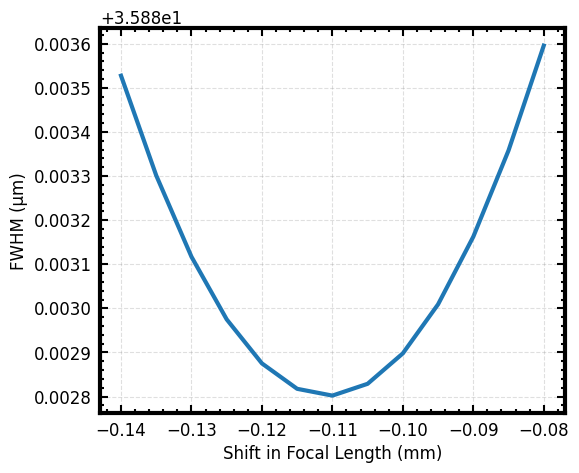

In [71]:
plt.plot(np.arange(-0.14,-0.08,0.005),fwhm_array_wout_first_lens)
plt.xlabel("Shift in Focal Length (mm)")
plt.ylabel("FWHM (μm)")
plt.show()

In [72]:
min(fwhm_array_wout_first_lens)

35.882802252092006

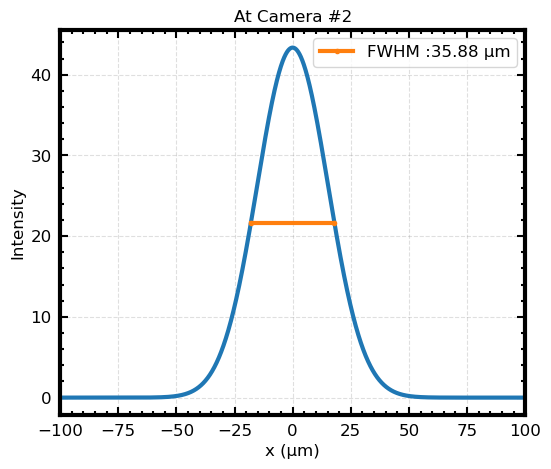

In [5]:
shift_in_focal_length_second_lens =- 0.11*mm

at_second_lens = collimated_beam * second_lens
without_first_lens = at_second_lens.RS(z= focal_length_second_lens + shift_in_focal_length_second_lens,verbose=False)
fwhm_without_first_lens = FWHM1D(without_first_lens.x,without_first_lens.intensity(),has_draw= False)




plt.plot(without_first_lens.x,without_first_lens.intensity())

#FWHM LINE
x1, y1 = [-fwhm_without_first_lens/2, fwhm_without_first_lens/2], [max(np.abs(without_first_lens.u)**2)/2, max(np.abs(without_first_lens.u)**2)/2]
plt.plot(x1, y1, marker = '.',label="FWHM :" + str(fwhm_without_first_lens)[:5]+ " µm")

plt.title("At Camera #2")
plt.xlabel("x (µm)")
plt.ylabel("Intensity")
plt.xlim(-100,100)
plt.legend()
plt.show()

# with 50mm Lens and 200mm Lens

Good result: factor 69.85
Good result: factor 338.84
Good result: factor 138.86


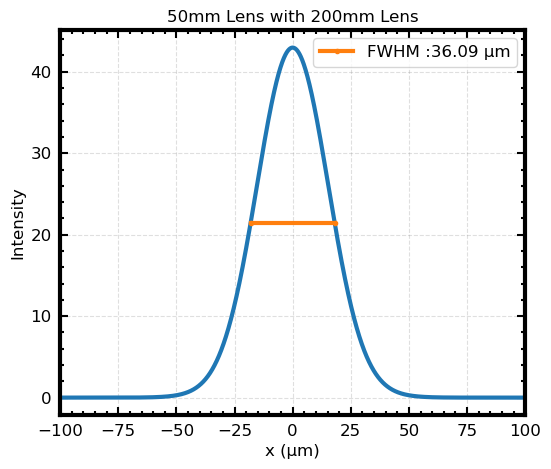

In [5]:
shift_in_focal_length_first_lens = -0.035*mm
shift_in_focal_length_second_lens =- 0.11*mm

D1=125.86* mm
D2=363.00* mm


at_first_lens = collimated_beam * first_lens

first_lens_2f = at_first_lens.RS(z=2*(focal_length_first_lens + shift_in_focal_length_first_lens ))

first_lens_twice = first_lens_2f * first_lens


before_second_lens = first_lens_twice.RS(z=D1+D2)
at_second_lens = before_second_lens * second_lens
after_second_lens = at_second_lens.RS(z=focal_length_second_lens + shift_in_focal_length_second_lens )

fwhm_after_second_lens = FWHM1D(after_second_lens.x,after_second_lens.intensity(),has_draw= False)


plt.plot(after_second_lens.x,after_second_lens.intensity())

#FWHM LINE
x1, y1 = [-fwhm_after_second_lens/2, fwhm_after_second_lens/2], [max(np.abs(after_second_lens.u)**2)/2, max(np.abs(after_second_lens.u)**2)/2]
plt.plot(x1, y1, marker = '.',label="FWHM :" + str(fwhm_after_second_lens)[:5]+ " µm")

plt.title("50mm Lens with 200mm Lens")
plt.xlabel("x (µm)")
plt.ylabel("Intensity")
plt.xlim(-100,100)
plt.legend()
plt.show()

# Small Lens

""" 
#25mm focal ----https://punchout.webdev02.thorlabs.com/newgrouppage9.cfm?objectgroup_id=7176&pn=AL1225-A
#Values for Aspheric Lens
lens_ratio = 100


a4= 1.8429898 * 10** -15
a6= -3.8172252 * 10** -24
a8= -2.4345457 * 10**-32 

a=[a4*lens_ratio**3,a6*lens_ratio**5,a8*lens_ratio**7]


k = -0.6
R=12.78 
depth = 4
size= 12.5

"""
"""
lens_ratio = 20

a4= -2.21* 10** -13 #https://www.thorlabs.com/drawings/4baae576e0b3cd15-57A727DB-C3B9-6796-C837C26E1B611408/ACL108U-AutoCADPDF.pdf

a=[a4]


k = -0.6027
R=4.185
""" 
lens_ratio = 1
Diameter=1.14*mm
k=-0.96307
R=0.840660*mm

a4= -9.476566 * 10** -11
a6= -2.790461 * 10** -15
a8=-5.415580 * 10**-24

a=[a4*lens_ratio**3,a6*lens_ratio**5,a8*lens_ratio**7] #https://www.thorlabs.com/thorproduct.cfm?partnumber=354140




lens_aspheric = Scalar_mask_X(range_of_second_lens, wavelength, n_background= 1)

lens_aspheric.aspheric(x0=0, c=1 / (R/lens_ratio), k=k, a=a, n0=1.5871, n1=1, radius=Diameter/(2*lens_ratio))

In [9]:
#Small Lens

lens_ratio = 1

small_lens_diameter = (1.1/lens_ratio) * mm
focal_length_small_lens = (720/lens_ratio)*um

small_lens = Scalar_mask_X(x=range_of_second_lens, wavelength=wavelength)
small_lens.lens(x0=0.0, focal=focal_length_small_lens, radius=small_lens_diameter/ 2)


array([1.      , 0.999992, 0.999984, ..., 0.999984, 0.999992, 1.      ])

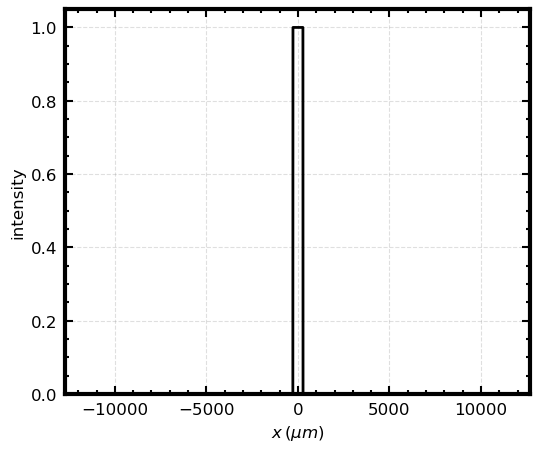

In [80]:
small_lens.draw()
plt.show()

In [67]:
fwhm_focus_of_small_lens = []
f_scan_range = np.arange(320,410,2)
for i in f_scan_range:
    
    at_small_lens = collimated_beam * small_lens
    focus_small_lens = at_small_lens.RS(z= i*um,verbose=False)
    fwhm_focus_small_lens = FWHM1D(focus_small_lens.x,focus_small_lens.intensity(),has_draw= False)
    fwhm_focus_of_small_lens.append(fwhm_focus_small_lens)
    

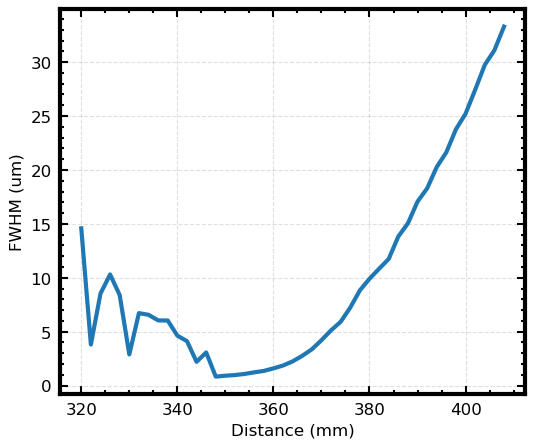

In [68]:
plt.plot(f_scan_range,fwhm_focus_of_small_lens)
plt.xlabel("Distance (mm)")
plt.ylabel("FWHM (um)")

plt.show()

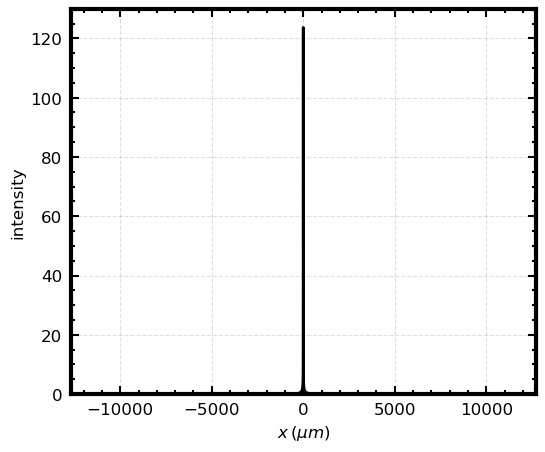

In [51]:
at_small_lens = collimated_beam * small_lens
focus_small_lens = at_small_lens.RS(z= 720*um,verbose=False)
focus_small_lens.draw() 
plt.show()

# Setup with Small Lens

In [77]:


fwhm_after_aspheric_2f_array = []
fwhm_before_first_lens_twice_array = []

shift_in_focal_length_first_lens = -0.035*mm
shift_in_focal_length_second_lens =- 0.11*mm

index_values = np.arange(-200,50,10)

for i in index_values:
    
    at_first_lens = collimated_beam * first_lens
    first_lens_f = at_first_lens.RS(z=1*(focal_length_first_lens + shift_in_focal_length_first_lens ),verbose=False)
    
    before_aspheric_lens = first_lens_f.RS(z=2*focal_length_small_lens + i*um,verbose=False)
    at_aspheric = before_aspheric_lens* small_lens

    first_lens_f_twice = at_aspheric.RS(z=2*focal_length_small_lens + i*um,verbose=False)
    fwhm_first_lens_f_twice = FWHM1D(first_lens_f_twice.x,first_lens_f_twice.intensity(),has_draw= False)
   
    
    
    before_first_lens_twice = first_lens_f_twice.RS(z=1*(focal_length_first_lens + shift_in_focal_length_first_lens ),verbose=False)
    fwhm_before_first_lens_twice = FWHM1D(before_first_lens_twice.x,before_first_lens_twice.intensity(),has_draw= False)
    
    fwhm_after_aspheric_2f_array.append(fwhm_first_lens_f_twice)
    fwhm_before_first_lens_twice_array.append(fwhm_before_first_lens_twice)

In [78]:
import pandas as pd
# Create fixed value arrays for the first two columns
fixed_column1 = np.full_like(fwhm_after_aspheric_2f_array, 1555)
fixed_column2 = np.full_like(fwhm_after_aspheric_2f_array, 8.983)

# Create a DataFrame using pandas
data = {
    "Collimated Beam": fixed_column1,
    "Before 50mm Twice": fwhm_before_first_lens_twice_array,
    "Focused by 50mm": fixed_column2,
    "After Aspheric 2x": fwhm_after_aspheric_2f_array,
}

df = pd.DataFrame(data, index=index_values+2*focal_length_small_lens)
pd.set_option('display.max_rows', None)

df["Collimated Beam"] = df["Collimated Beam"].apply(lambda x: '{:.0f}'.format(x))
df["Before 50mm Twice"] = df["Before 50mm Twice"].apply(lambda x: '{:.0f}'.format(x))
df["Focused by 50mm"] = df["Focused by 50mm"].apply(lambda x: '{:.3f}'.format(x))
df["After Aspheric 2x"] = df["After Aspheric 2x"].apply(lambda x: '{:.3f}'.format(x))

# Print the DataFrame
print(df)




      Collimated Beam Before 50mm Twice Focused by 50mm After Aspheric 2x
520.0            1555              1405           8.983            10.276
530.0            1555              1424           8.983            10.129
540.0            1555              1443           8.983             9.975
550.0            1555              1464           8.983             9.815
560.0            1555              1485           8.983             9.649
570.0            1555              1508           8.983             9.481
580.0            1555              1530           8.983             9.310
590.0            1555              1554           8.983             9.139
600.0            1555              1579           8.983             8.972
610.0            1555              1604           8.983             8.812
620.0            1555              1629           8.983             8.664
630.0            1555              1656           8.983             8.533
640.0            1555              168

In [74]:
excel_filename = "small_lens_ratio_2_f=360um.xlsx"
df.to_excel(excel_filename)


Good result: factor 338.84
Good result: factor 138.86


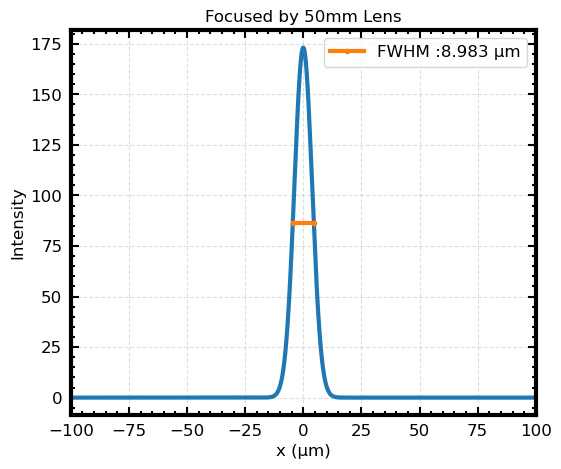

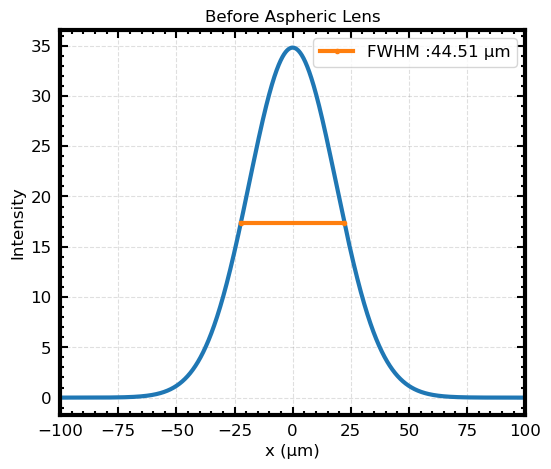

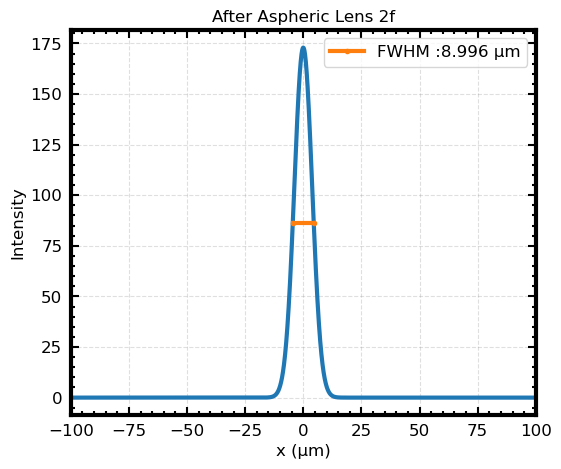

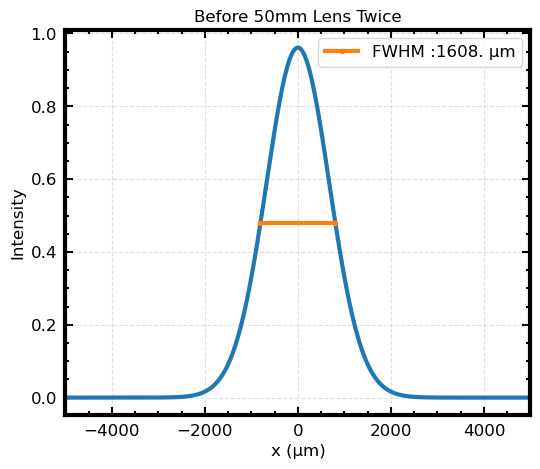

720.0


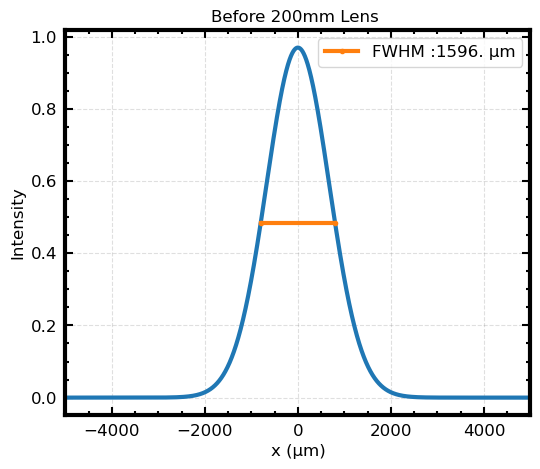

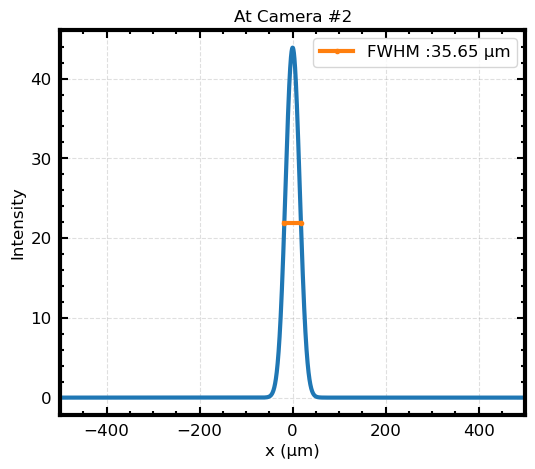

In [10]:
x=720*um

at_first_lens = collimated_beam * first_lens
first_lens_f = at_first_lens.RS(z=1*(focal_length_first_lens + shift_in_focal_length_first_lens ),verbose=False)
fwhm_first_lens_f = FWHM1D(first_lens_f.x,first_lens_f.intensity(),has_draw= False)
   
before_aspheric_lens = first_lens_f.RS(z=2*x ,verbose=False)
fwhm_before_aspheric_lens= FWHM1D(before_aspheric_lens.x,before_aspheric_lens.intensity(),has_draw= False)

at_aspheric = before_aspheric_lens* small_lens

first_lens_f_twice = at_aspheric.RS(z=2*x  ,verbose=False)
fwhm_first_lens_f_twice = FWHM1D(first_lens_f_twice.x,first_lens_f_twice.intensity(),has_draw= False)
   
    
    
before_first_lens_twice = first_lens_f_twice.RS(z=1*(focal_length_first_lens + shift_in_focal_length_first_lens ),verbose=False)
fwhm_before_first_lens_twice = FWHM1D(before_first_lens_twice.x,before_first_lens_twice.intensity(),has_draw= False)
    
    
    


at_first_lens_twice = before_first_lens_twice* first_lens

                                                
before_second_lens = at_first_lens_twice.RS(z=D1+D2)
at_second_lens = before_second_lens * second_lens
fwhm_at_second_lens = FWHM1D(at_second_lens.x,at_second_lens.intensity(),has_draw= False)


after_second_lens = at_second_lens.RS(z=focal_length_second_lens + shift_in_focal_length_second_lens )

fwhm_after_second_lens = FWHM1D(after_second_lens.x,after_second_lens.intensity(),has_draw= False)


# -------------------PLOT-----------------------------------------------



#Focused by 50mm
plt.plot(first_lens_f.x,first_lens_f.intensity())

#FWHM LINE
x1, y1 = [-fwhm_first_lens_f/2, fwhm_first_lens_f/2], [max(np.abs(first_lens_f.u)**2)/2, max(np.abs(first_lens_f.u)**2)/2]
plt.plot(x1, y1, marker = '.',label="FWHM :" + str(fwhm_first_lens_f)[:5]+ " µm")

plt.title("Focused by 50mm Lens")
plt.xlabel("x (µm)")
plt.ylabel("Intensity")
plt.xlim(-100,100)
plt.legend()
plt.show()


#Before Aspheric Lens
plt.plot(before_aspheric_lens.x,before_aspheric_lens.intensity())

#FWHM LINE
x1, y1 = [-fwhm_before_aspheric_lens/2, fwhm_before_aspheric_lens/2], [max(np.abs(before_aspheric_lens.u)**2)/2, max(np.abs(before_aspheric_lens.u)**2)/2]
plt.plot(x1, y1, marker = '.',label="FWHM :" + str(fwhm_before_aspheric_lens)[:5]+ " µm")

plt.title("Before Aspheric Lens")
plt.xlabel("x (µm)")
plt.ylabel("Intensity")
plt.xlim(-100,100)
plt.legend()
plt.show()


#After Aspheric Lens
plt.plot(first_lens_f_twice.x,first_lens_f_twice.intensity())

#FWHM LINE
x1, y1 = [-fwhm_first_lens_f_twice/2, fwhm_first_lens_f_twice/2], [max(np.abs(first_lens_f_twice.u)**2)/2, max(np.abs(first_lens_f_twice.u)**2)/2]
plt.plot(x1, y1, marker = '.',label="FWHM :" + str(fwhm_first_lens_f_twice)[:5]+ " µm")

plt.title("After Aspheric Lens 2f")
plt.xlabel("x (µm)")
plt.ylabel("Intensity")
plt.xlim(-100,100)
plt.legend()
plt.show()

#Before First Lens twice
plt.plot(before_first_lens_twice.x,before_first_lens_twice.intensity())

#FWHM LINE
x1, y1 = [-fwhm_before_first_lens_twice/2, fwhm_before_first_lens_twice/2], [max(np.abs(before_first_lens_twice.u)**2)/2, max(np.abs(before_first_lens_twice.u)**2)/2]
plt.plot(x1, y1, marker = '.',label="FWHM :" + str(fwhm_before_first_lens_twice)[:5]+ " µm")

plt.title("Before 50mm Lens Twice")
plt.xlabel("x (µm)")
plt.ylabel("Intensity")
plt.xlim(-5000,5000)
plt.legend()
plt.show()

print(x)

#Before Second Lens
plt.plot(at_second_lens.x,at_second_lens.intensity())

#FWHM LINE
x1, y1 = [-fwhm_at_second_lens/2, fwhm_at_second_lens/2], [max(np.abs(at_second_lens.u)**2)/2, max(np.abs(at_second_lens.u)**2)/2]
plt.plot(x1, y1, marker = '.',label="FWHM :" + str(fwhm_at_second_lens)[:5]+ " µm")

plt.title("Before 200mm Lens ")
plt.xlabel("x (µm)")
plt.ylabel("Intensity")
plt.xlim(-5000,5000)
plt.legend()
plt.show()



#At Camera #2
plt.plot(after_second_lens.x,after_second_lens.intensity())

#FWHM LINE
x1, y1 = [-fwhm_after_second_lens/2, fwhm_after_second_lens/2], [max(np.abs(after_second_lens.u)**2)/2, max(np.abs(after_second_lens.u)**2)/2]
plt.plot(x1, y1, marker = '.',label="FWHM :" + str(fwhm_after_second_lens)[:5]+ " µm")

plt.title("At Camera #2")
plt.xlabel("x (µm)")
plt.ylabel("Intensity")
plt.xlim(-500,500)
plt.legend()
plt.show()
